In [3]:
import torch
import torch.nn as nn
import sys
sys.path.append('/home/aiteam/tykim/cubox/diffusers/src')


import os
os.chdir('../../')

In [4]:
from src.diffusers.models.unet_2d_blocks import UNetMidBlockTimeless2D, get_down_block

In [8]:
from src.diffusers.models.attention import AdaGroupNorm
from src.diffusers.models.attention_processor import SpatialNorm
from functools import partial
import torch.nn.functional as F

In [ ]:
down_block_types = ("CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D")

In [ ]:
layers_per_block = 2


In [ ]:
class Tiem

In [7]:
# Upsample downsmaple 관련
def upsample_2d(hidden_states, kernel=None, factor=2, gain=1):
    r"""Upsample2D a batch of 2D images with the given filter.
    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]` and upsamples each image with the given
    filter. The filter is normalized so that if the input pixels are constant, they will be scaled by the specified
    `gain`. Pixels outside the image are assumed to be zero, and the filter is padded with zeros so that its shape is
    a: multiple of the upsampling factor.

    Args:
        hidden_states: Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        kernel: FIR filter of the shape `[firH, firW]` or `[firN]`
          (separable). The default is `[1] * factor`, which corresponds to nearest-neighbor upsampling.
        factor: Integer upsampling factor (default: 2).
        gain: Scaling factor for signal magnitude (default: 1.0).

    Returns:
        output: Tensor of the shape `[N, C, H * factor, W * factor]`
    """
    assert isinstance(factor, int) and factor >= 1
    if kernel is None:
        kernel = [1] * factor

    kernel = torch.tensor(kernel, dtype=torch.float32)
    if kernel.ndim == 1:
        kernel = torch.outer(kernel, kernel)
    kernel /= torch.sum(kernel)

    kernel = kernel * (gain * (factor**2))
    pad_value = kernel.shape[0] - factor
    output = upfirdn2d_native(
        hidden_states,
        kernel.to(device=hidden_states.device),
        up=factor,
        pad=((pad_value + 1) // 2 + factor - 1, pad_value // 2),
    )
    return output


def downsample_2d(hidden_states, kernel=None, factor=2, gain=1):
    r"""Downsample2D a batch of 2D images with the given filter.
    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]` and downsamples each image with the
    given filter. The filter is normalized so that if the input pixels are constant, they will be scaled by the
    specified `gain`. Pixels outside the image are assumed to be zero, and the filter is padded with zeros so that its
    shape is a multiple of the downsampling factor.

    Args:
        hidden_states: Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        kernel: FIR filter of the shape `[firH, firW]` or `[firN]`
          (separable). The default is `[1] * factor`, which corresponds to average pooling.
        factor: Integer downsampling factor (default: 2).
        gain: Scaling factor for signal magnitude (default: 1.0).

    Returns:
        output: Tensor of the shape `[N, C, H // factor, W // factor]`
    """

    assert isinstance(factor, int) and factor >= 1
    if kernel is None:
        kernel = [1] * factor

    kernel = torch.tensor(kernel, dtype=torch.float32)
    if kernel.ndim == 1:
        kernel = torch.outer(kernel, kernel)
    kernel /= torch.sum(kernel)

    kernel = kernel * gain
    pad_value = kernel.shape[0] - factor
    output = upfirdn2d_native(
        hidden_states, kernel.to(device=hidden_states.device), down=factor, pad=((pad_value + 1) // 2, pad_value // 2)
    )
    return output


def upfirdn2d_native(tensor, kernel, up=1, down=1, pad=(0, 0)):
    up_x = up_y = up
    down_x = down_y = down
    pad_x0 = pad_y0 = pad[0]
    pad_x1 = pad_y1 = pad[1]

    _, channel, in_h, in_w = tensor.shape
    tensor = tensor.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = tensor.shape
    kernel_h, kernel_w = kernel.shape

    out = tensor.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)])
    out = out.to(tensor.device)  # Move back to mps if necessary
    out = out[
        :,
        max(-pad_y0, 0) : out.shape[1] - max(-pad_y1, 0),
        max(-pad_x0, 0) : out.shape[2] - max(-pad_x1, 0),
        :,
    ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape([-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1])
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h) // down_y + 1
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w) // down_x + 1

    return out.view(-1, channel, out_h, out_w)


In [14]:
class FiLM(nn.Module):
    def __init__(self, input_dim, cond_dim):
        super().__init__()
        self.input_dim = input_dim
        self.linear = nn.Linear(cond_dim, input_dim*2)

    def forward(self, x, cond):
        c = self.linear(cond)
        gamma = c[..., :self.input_dim]
        beta = c[..., self.input_dim:]
        return gamma*x + beta

l = FiLM(3, 6)
l(torch.randn(10, 3), torch.randn(10, 6))

tensor([[ 0.7316,  0.1500,  0.0487],
        [ 0.1029, -0.1350, -0.5309],
        [ 1.7451,  0.3637,  0.0163],
        [ 1.0498, -0.1450,  0.8375],
        [-0.1955,  1.1234,  0.4140],
        [-0.0491, -0.1049,  0.5884],
        [ 0.6834,  0.0091, -0.9983],
        [ 0.4059, -0.0439,  0.4895],
        [ 0.0519, -1.1444,  0.3726],
        [-1.2727, -0.5693, -0.7939]], grad_fn=<AddBackward0>)

In [15]:
from einops import rearrange

In [16]:
q = torch.randn(3, 2, 16)
k = torch.randn(3, 2, 24)

In [17]:
q, k = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = 8), (q, k))

In [19]:
q.shape, k.shape

(torch.Size([3, 8, 2, 2]), torch.Size([3, 8, 2, 3]))

In [ ]:
class Attend(nn.Moduel):
    def forward(self, dropoiut=0., causal=False, use_flash=False):
        

class Attention(nn.Module):
    def __init__(self, 
                 dim_head=64,
                 heads=8):
        super().__init__()
        self.scale = dim_head * -0.5
        self.heads = heads
        self.cross_attn_include_queries = cross
        self.attend = Attend(causal=causal, dropout=dropout, use_flash=use_flash)
        self.to_q = nn.Linear(dim, dim_inner, bias=False)
        self.to_kv = nn.Linear(dim_context, dim_inner*2, bias=False)
        self.to_out = nn.Linear(dim_inner, bias=False)
    def forward(self, x, conext=None, mask=None):
        h, has_conetxt = self.heads, exists(conext)

        context = default(context, x)

        if has_context:
            ...

        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim=-1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h),(q, k, v))

        out = self.attend(q,k,v, mask=mask)

        out = rearrange('b h n d -> b n (h d)')
        return self.to_out(out)
    

In [ ]:
class Block(nn.Module):
    """
    cond 정보를 전달 받는 ResBlock
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        time_embedding_norm="default",
        kernel=None,
        
    ):
        super().__init__()
        self.pre_norm = True
        self.time_embedding_norm = time_embedding_norm
        

        #### Time embedding 처리를 위해 ####
        if groups_out is None:
            groups_out = groups

            
        if temb_channels is not None:
            if self.time_embedding_norm == "default":
                self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
            elif self.time_embedding_norm == "scale_shift":
                self.time_emb_proj = torch.nn.Linear(temb_channels, 2 * out_channels)
            elif self.time_embedding_norm == "ada_group" or self.time_embedding_norm == "spatial":
                self.time_emb_proj = None
            else:
                raise ValueError(f"unknown time_embedding_norm : {self.time_embedding_norm} ")
        else:
            self.time_emb_proj = None

            
        if self.time_embedding_norm == "ada_group":
            self.norm2 = AdaGroupNorm(temb_channels, out_channels, groups_out, eps=eps)
        elif self.time_embedding_norm == "spatial":
            self.norm2 = SpatialNorm(out_channels, temb_channels)
        else:
            self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)

        ###################################

        ############ 첫번째 conv ##########
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.dropout = torch.nn.Dropout(dropout)
        # 만약 두 번째 conv에서 나오는 채널 값이 달라진다면
        conv_2d_out_channels = conv_2d_out_channels or out_channels
        self.conv2 = torch.nn.Conv2d(out_channels, conv_2d_out_channels, kernel_size=3, stride=1, padding=1)

        
        ############ Up or Down ##########
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, kernel=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, kernel=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")


        ############ Shortcut connection ##########
        # 설정  :일단 있는지 확인하고 in_channels과 out_channel`s수가 다르다면 무조건 True
        self.use_in_shortcut = self.in_channels != conv_2d_out_channels if use_in_shortcut is None else use_in_shortcut

    def forward(self, input_tensor, temb=None, cond=None, lateral=None):
        """
        lateral : from encoder
        pre-norm > act > (up or down) : option > conv
        """
        # prepare
        hidden_states = input_tensor
        if self.lateral_handling == 'concat':
            hidden_states = torch.concat([input_tensor, lateral], dim=1)
        elif self.lateral_handling == 'attn':
            ...
            

        # pre-norm
        if self.time_embedding_norm == "ada_group" or self.time_embedding_norm == "spatial":
            # temb를 scale and shift한다면
            hidden_states = self.norm1(hidden_states, temb)
        else:
            hidden_states = self.norm1(hidden_states)

        # activation
        hidden_states = self.nonlinearity(hidden_states)

        # up or down 있다면 (input과 hidden 둘 다 적용)
        if self.upsample is not None:
            input_tensor = self.upsample(input_tensor)
            hidden_states = self.upsample(hidden_states)
        elif self.downsample is not None:
            input_tensor = self.downsample(input_tensor)
            hidden_states = self.downsample(hidden_states)

        # 첫번쨰 conv
        hidden_states = self.conv1(hidden_states)
        

In [ ]:
class CrossAttnDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        temb_channels: int,
        
    ):
        super().__init__()

    def forward(self, hidden_states, temb=None, encoder_hidden_states = None,
                attention_mask=None, cross_attention_kwargs=None, encoder_attention_mask= None,):
        output_states = ()

        for resnet, attn in zip(self.resnets, self.attentions):
            if self.training and 

In [ ]:
get_down_block("CrossAttnDownBlock2D",
               layers_per_block=2, 
               in_channels=32,
               out_channels=64,
               
               )

In [6]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

from datasets import load_dataset

In [7]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", cache_dir='/home/aiteam/tykim/cubox/diffusers/examples/sidm/datasets', split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/aiteam/tykim/cubox/diffusers/examples/sidm/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


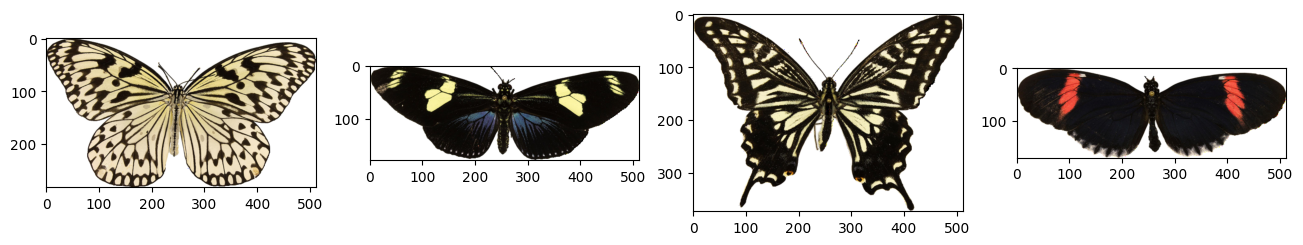

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
fig.show()    

In [14]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [15]:
def transform(examples):
    images = [preprocess(image.convert("RGB"))for image in examples["image"]]
    return {"images" : images}

dataset.set_transform(transform)

In [17]:
dataset[0]["images"].shape

torch.Size([3, 128, 128])

In [18]:
sample_image = dataset[0]["images"].unsqueeze(0)

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])

In [22]:
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

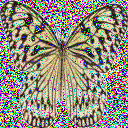

In [23]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
# notebook에서 돌릴 떄
def train_loop(config, model, noise_scheduler, optimizer, train):
    

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
class TestModel(nn.Module):
    